In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/factors-affecting-campus-placement/Placement_Data_Full_Class.csv


In [2]:
# all the necessary libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection
import sklearn.preprocessing as pre

from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_classification

#models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# 1. Importing Data

In [3]:
main_df = pd.read_csv(r'/kaggle/input/factors-affecting-campus-placement/Placement_Data_Full_Class.csv', index_col='sl_no')
print(f'Shape : {main_df.shape}')
main_df.head()

Shape : (215, 14)


,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
sl_no,,,,,,,,,,,,,,
1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [4]:
# to have a look at the general overview of the entire data
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 1 to 215
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    object 
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    object 
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    object 
 5   hsc_s           215 non-null    object 
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    object 
 8   workex          215 non-null    object 
 9   etest_p         215 non-null    float64
 10  specialisation  215 non-null    object 
 11  mba_p           215 non-null    float64
 12  status          215 non-null    object 
 13  salary          148 non-null    float64
dtypes: float64(6), object(8)
memory usage: 25.2+ KB


In [5]:
# to get the exact number of missing values in the column.
main_df.isnull().sum()

gender             0
ssc_p              0
ssc_b              0
hsc_p              0
hsc_b              0
hsc_s              0
degree_p           0
degree_t           0
workex             0
etest_p            0
specialisation     0
mba_p              0
status             0
salary            67
dtype: int64

In [6]:
# check if the status is no places
main_df['status'].value_counts()

Placed        148
Not Placed     67
Name: status, dtype: int64

In [7]:
# Does all the rows with missing values have a status of Not Placed?

status_df = main_df[main_df['status']=='Not Placed']
print('Shape of the dataframe:',status_df.shape, sep ='\n', end ='\n\n')
print('Number of rows with status as Not Placed:',status_df['status'].value_counts(), sep ='\n', end ='\n\n')
print('Number of rows with salary as zero:',status_df['salary'].isnull().sum(), sep ='\n', end ='\n\n')

Shape of the dataframe:
(67, 14)

Number of rows with status as Not Placed:
Not Placed    67
Name: status, dtype: int64

Number of rows with salary as zero:
67



### Insights:
- We see that all rows with Status as 'Not Placed' have the salary as 'Nan', which is logical.
- **Recomended change:**
    - Drop the Salary column as using that we can predict the Placed status with an if statment.
> If the value is not Nan then the person is placed or else he is not.
In real life we won't have such a column telling us these things.

In [8]:
# segrigating all the numeric and categorical columns
num_cols = list(main_df.select_dtypes(exclude=['object']).columns)
cat_cols = list(main_df.select_dtypes(include=['object']).columns)
print('all the numeric cols: ',num_cols, end ='\n\n')
print('all the categorical cols:',cat_cols, end ='\n\n')

all the numeric cols:  ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p', 'salary']

all the categorical cols: ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation', 'status']



In [9]:
main_df[num_cols].describe()

,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000
mean,67.303395,66.333163,66.370186,72.100558,62.278186,288655.405405
std,10.827205,10.897509,7.358743,13.275956,5.833385,93457.452420
min,40.890000,37.000000,50.000000,50.000000,51.210000,200000.000000
25%,60.600000,60.900000,61.000000,60.000000,57.945000,240000.000000
50%,67.000000,65.000000,66.000000,71.000000,62.000000,265000.000000
75%,75.700000,73.000000,72.000000,83.500000,66.255000,300000.000000
max,89.400000,97.700000,91.000000,98.000000,77.890000,940000.000000


In [10]:
main_df[cat_cols].describe()

,gender,ssc_b,hsc_b,hsc_s,degree_t,workex,specialisation,status
count,215,215,215,215,215,215,215,215
unique,2,2,2,3,3,2,2,2
top,M,Central,Others,Commerce,Comm&Mgmt,No,Mkt&Fin,Placed
freq,139,116,131,113,145,141,120,148


# 2. Data Visualisation

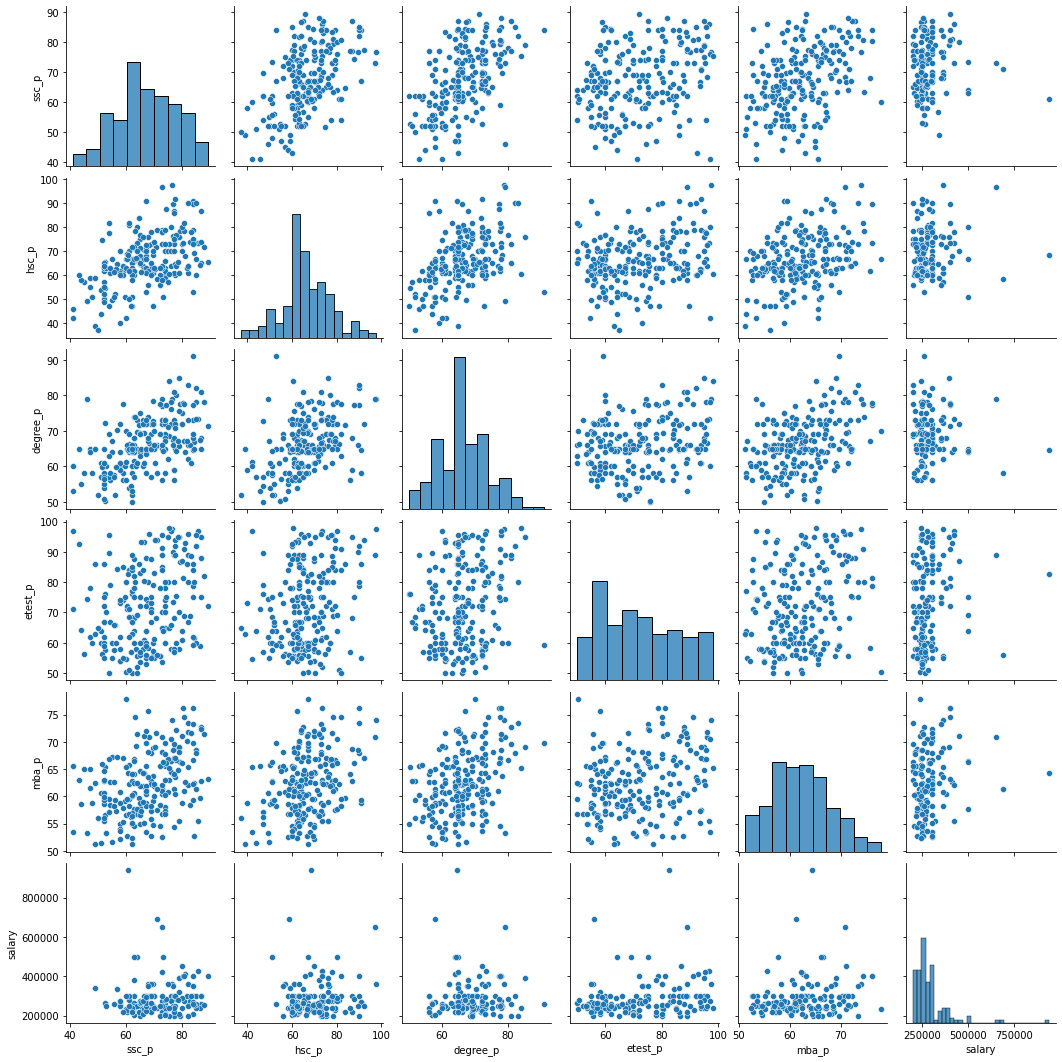

In [11]:
sns.pairplot(main_df[num_cols])

#### Insights:
- ***hsc_p*** and ***ssc_p*** have a high correlation: ***0.51***
- ***degree_p*** and ***ssc_p*** have a high correlation: ***0.54***
- ***hsc_p*** and ***degree_p*** have a high correlation: ***0.43***
- ***mba_p*** and ***ssc_p*** have a high correlation: ***0.39***

> Removing ***hsc_p***, ***degree_p*** and ***mba_p*** and keeping ***ssc_p***, would be a good choice as ***ssc_p explains the other 2 columns as well.***

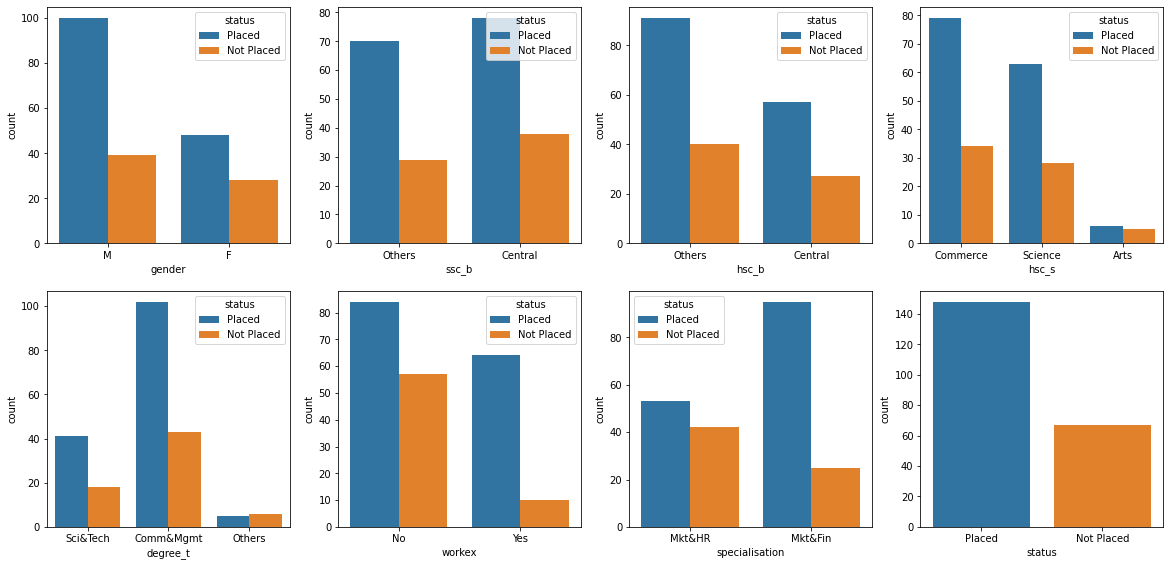

In [12]:
#Change the figure size
plt.figure(figsize=[20, 20])

for i in range(len(cat_cols)):
    plt.subplot(4, 4, i+1)
    if(i<7):
        sns.countplot(x = main_df[cat_cols[i]], hue = main_df['status'])
    else:
        sns.countplot(x = main_df[cat_cols[i]])
plt.show()

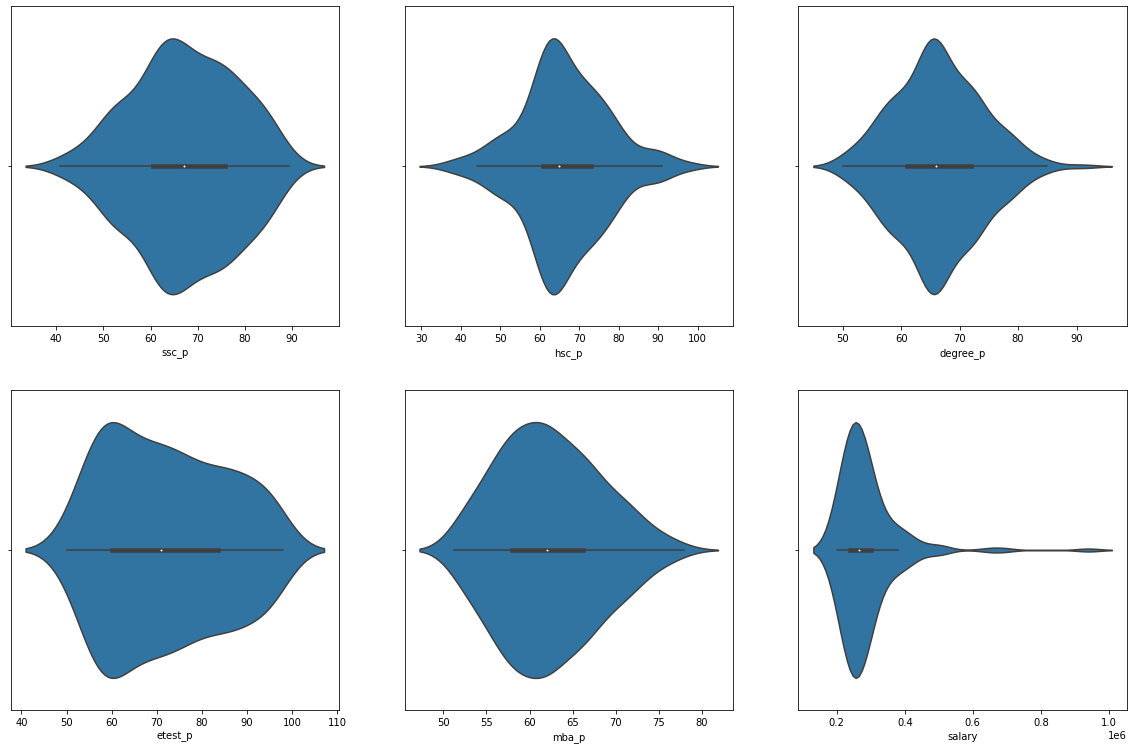

In [13]:
#Change the figure size
plt.figure(figsize=[20, 20])

for i in range(len(num_cols)):
    plt.subplot(3, 3, i+1)
    sns.violinplot(x = main_df[num_cols[i]], hue = main_df['status'])
plt.show()

### Insights:
- All the columns seem to be normaly disributed except the salary column.
- No outlier treatment required as we are going to drop the salary column as it is.

# 3. Data Transformation

In [14]:
transform_df_1 = main_df.drop(['salary'], axis=1)
transform_df_1.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
sl_no,,,,,,,,,,,,,
1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


## 3.1 Numeric to Categorical

In [15]:
num_cols.remove('salary')
num_cols

['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']

In [16]:
transform_df_1[num_cols].describe()

,ssc_p,hsc_p,degree_p,etest_p,mba_p
count,215.000000,215.000000,215.000000,215.000000,215.000000
mean,67.303395,66.333163,66.370186,72.100558,62.278186
std,10.827205,10.897509,7.358743,13.275956,5.833385
min,40.890000,37.000000,50.000000,50.000000,51.210000
25%,60.600000,60.900000,61.000000,60.000000,57.945000
50%,67.000000,65.000000,66.000000,71.000000,62.000000
75%,75.700000,73.000000,72.000000,83.500000,66.255000
max,89.400000,97.700000,91.000000,98.000000,77.890000


### Insights:
***Ranges***
- ssc_p <code>[40.89 to 89.40]</code>
- hsc_p <code>[37 to 97.7]</code>
- degree_p <code>[50 to 91]</code>
- etest_p <code>[50 to 98]</code>
- mba_p <code>[51.21 to 77.89]</code>

In [17]:
def get_bins(df, col_name, bin_num):
    lower = df[col_name].min()
    upper = df[col_name].max()
    bins = np.linspace(lower,upper,bin_num+1)
    return bins

# example :
print(get_bins(transform_df_1, 'ssc_p', 3))

[40.89 57.06 73.23 89.4 ]


In [18]:
for i in (num_cols):
    transform_df_1[i] = pd.cut(transform_df_1[i], bins=get_bins(transform_df_1, i, 2), labels=[0,1], include_lowest=True)
    
print(transform_df_1[num_cols].info())
transform_df_1[num_cols].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 1 to 215
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ssc_p     215 non-null    category
 1   hsc_p     215 non-null    category
 2   degree_p  215 non-null    category
 3   etest_p   215 non-null    category
 4   mba_p     215 non-null    category
dtypes: category(5)
memory usage: 11.4 KB
None


,ssc_p,hsc_p,degree_p,etest_p,mba_p
sl_no,,,,,
1,1,1,0,0,0
2,1,1,1,1,1
3,0,1,0,1,0
4,0,0,0,0,0
5,1,1,1,1,0


In [19]:
# converting the categorical columns to integer columns
for i in num_cols:
    transform_df_1[i] = transform_df_1[i].astype(int)
transform_df_1[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 1 to 215
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ssc_p     215 non-null    int64
 1   hsc_p     215 non-null    int64
 2   degree_p  215 non-null    int64
 3   etest_p   215 non-null    int64
 4   mba_p     215 non-null    int64
dtypes: int64(5)
memory usage: 18.2 KB


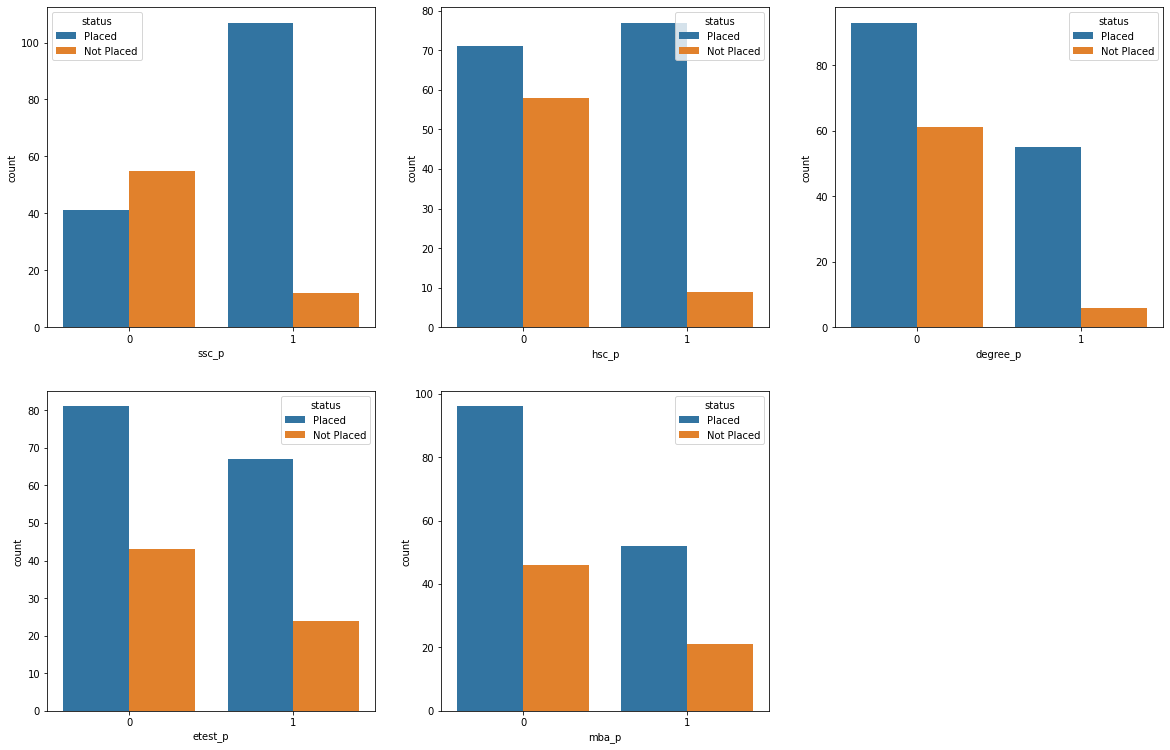

In [20]:
#Change the figure size
plt.figure(figsize=[20, 20])

for i in range(len(num_cols)):
    plt.subplot(3, 3, i+1)
    if(i<7):
        sns.countplot(x = transform_df_1[num_cols[i]], hue = transform_df_1['status'])
    else:
        sns.countplot(x = transform_df_1[num_cols[i]])
plt.show()

### Homework:
- make insights for the above graph.

## 3.2 Label Encode the Categorical Columns

In [21]:
# converting the object type values into numeric
labelencoder = pre.LabelEncoder()
for i in cat_cols:
    transform_df_1[i] = labelencoder.fit_transform(transform_df_1[i])
transform_df_1[cat_cols].head()

,gender,ssc_b,hsc_b,hsc_s,degree_t,workex,specialisation,status
sl_no,,,,,,,,
1,1,1,1,1,2,0,1,1
2,1,0,1,2,2,1,0,1
3,1,0,0,0,0,0,0,1
4,1,0,0,2,2,0,1,0
5,1,0,0,1,0,0,0,1


## 3.3 Feature Selection
ref : 

<AxesSubplot:>

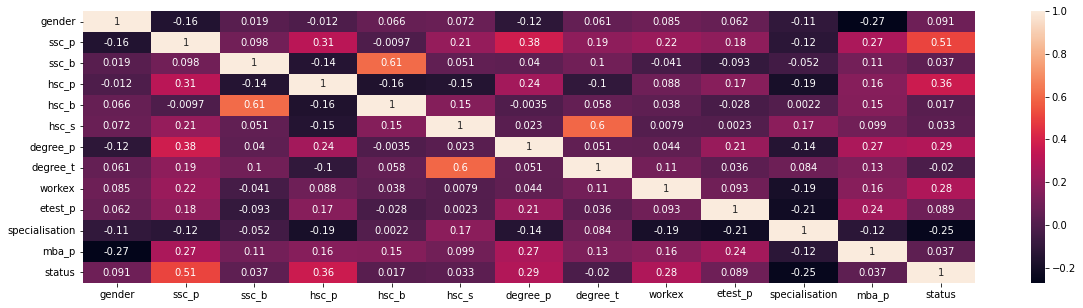

In [22]:
plt.figure(figsize=[20, 5])
sns.heatmap(transform_df_1.corr(), annot=True)

In [23]:
# from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(transform_df_1.drop('status', axis =1),transform_df_1['status'])
mutual_info

array([0.00233236, 0.14729736, 0.01821187, 0.05518083, 0.        ,
       0.04535597, 0.        , 0.        , 0.05354748, 0.        ,
       0.08174737, 0.        ])

In [24]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = transform_df_1.drop('status', axis=1).columns
mutual_info.sort_values(ascending=False)

ssc_p             0.147297
specialisation    0.081747
hsc_p             0.055181
workex            0.053547
hsc_s             0.045356
ssc_b             0.018212
gender            0.002332
hsc_b             0.000000
degree_p          0.000000
degree_t          0.000000
etest_p           0.000000
mba_p             0.000000
dtype: float64

## Insights:
- In this case we can take the columns that provide some info and drop the ones that don't
- Generally we take the top n columns, n defines the number of columns that the user wants to take into cosideration. <code>(Generally 5 or 10)</code>

In [25]:
# select colums that have non-zero mutual information
sel_cols=[]
for i in range(len(mutual_info)):
    if(mutual_info[i]>0):
        sel_cols.append(mutual_info.index[i])
sel_cols.append('status')
print(sel_cols)

['gender', 'ssc_p', 'ssc_b', 'hsc_p', 'hsc_s', 'workex', 'specialisation', 'status']


In [26]:
transform_df_2 = transform_df_1[sel_cols]
transform_df_2.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_s,workex,specialisation,status
sl_no,,,,,,,,
1,1,1,1,1,1,0,1,1
2,1,1,0,1,2,1,0,1
3,1,0,0,1,0,0,0,1
4,1,0,0,0,2,0,1,0
5,1,1,0,1,1,0,0,1


In [27]:
# from sklearn.feature_selection import SelectKBest
transform_df_3 = transform_df_1
sel_top5 = SelectKBest(mutual_info_classif, k=5)
sel_top5.fit(transform_df_3.drop('status', axis = 1), transform_df_3['status'])

# to see which are the top5 columns:
list(transform_df_3.drop('status', axis=1).columns[sel_top5.get_support()])

['ssc_p', 'hsc_p', 'degree_p', 'degree_t', 'workex']

In [28]:
sel_top5 = list(transform_df_3.drop('status', axis=1).columns[sel_top5.get_support()])
sel_top5.append('status')
transform_df_3 = transform_df_3[sel_top5]
transform_df_3.head()

,ssc_p,hsc_p,degree_p,degree_t,workex,status
sl_no,,,,,,
1,1,1,0,2,0,1
2,1,1,1,2,1,1
3,0,1,0,0,0,1
4,0,0,0,2,0,0
5,1,1,1,0,0,1


**NOTE**
- transform_df_1 : all the columns
- transform_df_2 : the columns with some mutual information
- transform_df_3 : the top 5 columns with mutual information

# 4. Model Selection

In [29]:
def average_accuracy(df, model):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=12) 
    all_accuracy = []
    
    X = df.drop('status', axis = 1)
    y = df['status']
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train) 
        all_accuracy.append(model.score(X_test, y_test))
    all_accuracy = sum(all_accuracy)/len(all_accuracy)
    return all_accuracy

## 4.1 Logistic Regression

In [30]:
log_r = LogisticRegression()
print('transform_df_1: {:.4f}'.format(average_accuracy(transform_df_1,log_r)))
print('transform_df_2: {:.4f}'.format(average_accuracy(transform_df_2,log_r)))
print('transform_df_3: {:.4f}'.format(average_accuracy(transform_df_3,log_r)))

transform_df_1: 0.8175
transform_df_2: 0.7898
transform_df_3: 0.7944


## 4.2 KNN

In [31]:
knn = KNeighborsClassifier(n_neighbors=5,algorithm='brute')
print('transform_df_1: {:.4f}'.format(average_accuracy(transform_df_1,knn)))
print('transform_df_2: {:.4f}'.format(average_accuracy(transform_df_2,knn)))
print('transform_df_3: {:.4f}'.format(average_accuracy(transform_df_3,knn)))

transform_df_1: 0.7517
transform_df_2: 0.7483
transform_df_3: 0.7567


## 4.3 Naive Bayes

In [32]:
nb = GaussianNB() # create a classifier
print('transform_df_1: {:.4f}'.format(average_accuracy(transform_df_1,nb)))
print('transform_df_2: {:.4f}'.format(average_accuracy(transform_df_2,nb)))
print('transform_df_3: {:.4f}'.format(average_accuracy(transform_df_3,nb)))

transform_df_1: 0.7710
transform_df_2: 0.7896
transform_df_3: 0.7848


## 4.4 SVM

In [33]:
svm = SVC(kernel='linear',class_weight={0:5, 1:5},probability=True)
print('transform_df_1: {:.4f}'.format(average_accuracy(transform_df_1,svm)))
print('transform_df_2: {:.4f}'.format(average_accuracy(transform_df_2,svm)))
print('transform_df_3: {:.4f}'.format(average_accuracy(transform_df_3,svm)))

transform_df_1: 0.7855
transform_df_2: 0.7667
transform_df_3: 0.7755


## 4.5 Decision Trees

In [34]:
dtree = DecisionTreeClassifier()
print('transform_df_1: {:.4f}'.format(average_accuracy(transform_df_1,dtree)))
print('transform_df_2: {:.4f}'.format(average_accuracy(transform_df_2,dtree)))
print('transform_df_3: {:.4f}'.format(average_accuracy(transform_df_3,dtree)))

transform_df_1: 0.6922
transform_df_2: 0.7251
transform_df_3: 0.7662


#### For this experiment we will just use transform_df_3 as it seem to give the best accuracy for all the models (approximately)

In [35]:
print('Logistic Refression: {:.4f}'.format(average_accuracy(transform_df_3,log_r)))
print('KNN: {:.4f}'.format(average_accuracy(transform_df_3,knn)))
print('Naive Bayes: {:.4f}'.format(average_accuracy(transform_df_3,nb)))
print('SVM: {:.4f}'.format(average_accuracy(transform_df_3,svm)))
print('Decision Trees: {:.4f}'.format(average_accuracy(transform_df_3,dtree)))

Logistic Refression: 0.7944
KNN: 0.7567
Naive Bayes: 0.7848
SVM: 0.7755
Decision Trees: 0.7662


# 5. Ensemble Technique

## 5.1 Bagging

In [36]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='entropy', max_depth=9,random_state=121, max_leaf_nodes =3)
print('Random Forest: {:.4f}'.format(average_accuracy(transform_df_3,rfc)))

Random Forest: 0.8039


In [37]:
# Bagging Classifiers:
from sklearn.ensemble import BaggingClassifier

# Logistic Regression
bag_lr = BaggingClassifier(base_estimator=LogisticRegression(class_weight={0:2, 1:1}),
                       n_estimators=100, random_state= 121)

# KNN
bag_knn = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=5,algorithm='brute'),
                       n_estimators=100, random_state= 121)

# Naive Bayes
bag_nb = BaggingClassifier(base_estimator=GaussianNB(),
                       n_estimators=100, random_state= 121)

# SVM
bag_svm = BaggingClassifier(base_estimator=SVC(kernel='linear',class_weight={0:5, 1:5}),
                       n_estimators=100, random_state= 121)
# Decision Tree
bag_dt = BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', 
                                                              max_depth=9,random_state=121, max_leaf_nodes =3),
                       n_estimators=100, random_state= 121)


print('Bagging Logistic Refression: {:.4f}'.format(average_accuracy(transform_df_3,bag_lr)))
print('Baggin KNN: {:.4f}'.format(average_accuracy(transform_df_3,bag_knn)))
print('Baggin Naive Bayes: {:.4f}'.format(average_accuracy(transform_df_3,bag_nb)))
print('Baggin SVM: {:.4f}'.format(average_accuracy(transform_df_3,bag_svm)))
print('Baggin Decision Trees: {:.4f}'.format(average_accuracy(transform_df_3,bag_dt)))

Bagging Logistic Refression: 0.7621
Baggin KNN: 0.7760
Baggin Naive Bayes: 0.7848
Baggin SVM: 0.7991
Baggin Decision Trees: 0.7712


In [38]:
# Using Voting classifier to simulate Bagging
from sklearn.ensemble import VotingClassifier
voting_clf_hard = VotingClassifier(estimators=[('Logistic Regression',log_r),
                                               ('KNN', knn),
                                               ('Naive Bayes', nb),
                                               ('SVM', svm),
                                               ('Decision Tree', dtree)], 
                                   voting = 'hard')

print('Hard Voting Classifier: {:.4f}'.format(average_accuracy(transform_df_3,voting_clf_hard)))

voting_clf_soft = VotingClassifier(estimators=[('Logistic Regression',log_r),
                                               ('KNN', knn),
                                               ('Naive Bayes', nb),
                                               ('SVM', svm),
                                               ('Decision Tree', dtree)], 
                                   voting = 'soft')

print('Soft Voting Classifier: {:.4f}'.format(average_accuracy(transform_df_3,voting_clf_soft)))

Hard Voting Classifier: 0.7896
Soft Voting Classifier: 0.7848


## 5.2 Boosting

In [39]:
# Boosting Classifiers:

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# Logistic Regression
ada_lr = AdaBoostClassifier(base_estimator=LogisticRegression(class_weight={0:2, 1:1}),
                       n_estimators=100, random_state= 121)

# KNN
ada_knn = GradientBoostingClassifier(init=KNeighborsClassifier(n_neighbors=5,algorithm='brute'),
                       n_estimators=100, random_state= 121)

# Naive Bayes
ada_nb = AdaBoostClassifier(base_estimator=GaussianNB(),
                       n_estimators=100, random_state= 121)

# SVM
ada_svm = GradientBoostingClassifier(init=SVC(kernel='linear',class_weight={0:5, 1:5},probability=True),
                       n_estimators=100, random_state= 121)

# Decision Tree
ada_dt = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', 
                                                              max_depth=9,random_state=121, max_leaf_nodes =3),
                       n_estimators=100, random_state= 121)

print('Boosting Logistic Refression: {:.4f}'.format(average_accuracy(transform_df_3,ada_lr)))
print('Boosting KNN: {:.4f}'.format(average_accuracy(transform_df_3,ada_knn)))
print('Boosting Naive Bayes: {:.4f}'.format(average_accuracy(transform_df_3,ada_nb)))
print('Boosting SVM: {:.4f}'.format(average_accuracy(transform_df_3,ada_svm)))
print('Boosting Decision Trees: {:.4f}'.format(average_accuracy(transform_df_3,ada_dt)))

Boosting Logistic Refression: 0.3115
Boosting KNN: 0.6422
Boosting Naive Bayes: 0.4693
Boosting SVM: 0.7662
Boosting Decision Trees: 0.7667


In [40]:

# Logistic Regression
gb_lr = GradientBoostingClassifier(init=LogisticRegression(class_weight={0:2, 1:1}),
                       n_estimators=100, random_state= 121)

# KNN
gb_knn = GradientBoostingClassifier(init=KNeighborsClassifier(n_neighbors=5,algorithm='brute'),
                       n_estimators=100, random_state= 121)

# Naive Bayes
gb_nb = GradientBoostingClassifier(init=GaussianNB(),
                       n_estimators=100, random_state= 121)

# SVM
gb_svm = GradientBoostingClassifier(init=SVC(kernel='linear',class_weight={0:5, 1:5},probability=True),
                       n_estimators=100, random_state= 121)

# Decision Tree
gb_dt = GradientBoostingClassifier(init=DecisionTreeClassifier(criterion='entropy', 
                                                              max_depth=9,random_state=121, max_leaf_nodes =3),
                       n_estimators=100, random_state= 121)

print('Boosting Logistic Refression: {:.4f}'.format(average_accuracy(transform_df_3,gb_lr)))
print('Boosting KNN: {:.4f}'.format(average_accuracy(transform_df_3,gb_knn)))
print('Boosting Naive Bayes: {:.4f}'.format(average_accuracy(transform_df_3,gb_nb)))
print('Boosting SVM: {:.4f}'.format(average_accuracy(transform_df_3,gb_svm)))
print('Boosting Decision Trees: {:.4f}'.format(average_accuracy(transform_df_3,gb_dt)))

Boosting Logistic Refression: 0.7662
Boosting KNN: 0.6422
Boosting Naive Bayes: 0.7710
Boosting SVM: 0.7662
Boosting Decision Trees: 0.7615


In [41]:
# over sampling to test the actual results:
from imblearn.over_sampling import RandomOverSampler
# OverSampling and UnderSampling the transformdf_1
X = transform_df_3.drop('status', axis =1)
y = transform_df_3['status']

print('Before sampling:',pd.Series(y).value_counts(),end='\n\n',sep='\n')
# define dataset
X, y = make_classification(n_samples=200, weights=[0.70], flip_y=0)

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)

print('After sampling:',pd.Series(y_over).value_counts(),sep='\n')

Before sampling:
1    148
0     67
Name: status, dtype: int64

After sampling:
0    140
1    140
dtype: int64


In [42]:
def KFold_accuracy(X,y,model):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=12) 
    all_accuracy = []
        
    for train_index, test_index in skf.split(X, y):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        
        model.fit(X_train, y_train) 
        all_accuracy.append(model.score(X_test, y_test))
    all_accuracy = sum(all_accuracy)/len(all_accuracy)
    return all_accuracy

In [43]:
# Ramdom Forest
print('Random Forest: {:.4f}'.format(KFold_accuracy(X_over,y_over,rfc)),end='\n\n')

# Bagging:
print('Bagging Logistic Refression: {:.4f}'.format(KFold_accuracy(X_over,y_over,bag_lr)))
print('Baggin KNN: {:.4f}'.format(KFold_accuracy(X_over,y_over,bag_knn)))
print('Baggin Naive Bayes: {:.4f}'.format(KFold_accuracy(X_over,y_over,bag_nb)))
print('Baggin SVM: {:.4f}'.format(KFold_accuracy(X_over,y_over,bag_svm)))
print('Baggin Decision Trees: {:.4f}'.format(KFold_accuracy(X_over,y_over,bag_dt)),end='\n\n')

# Voting Classifier
print('Hard Voting Classifier: {:.4f}'.format(KFold_accuracy(X_over,y_over,voting_clf_hard)))
print('Soft Voting Classifier: {:.4f}'.format(KFold_accuracy(X_over,y_over,voting_clf_soft)), end='\n\n')

# AdaBoosting
print('Boosting Logistic Refression: {:.4f}'.format(KFold_accuracy(X_over,y_over,ada_lr)))
print('Boosting KNN: {:.4f}'.format(KFold_accuracy(X_over,y_over,ada_knn)))
print('Boosting Naive Bayes: {:.4f}'.format(KFold_accuracy(X_over,y_over,ada_nb)))
print('Boosting SVM: {:.4f}'.format(KFold_accuracy(X_over,y_over,ada_svm)))
print('Boosting Decision Trees: {:.4f}'.format(KFold_accuracy(X_over,y_over,ada_dt)), end='\n\n')

# Gradient Boosting
print('Boosting Logistic Refression: {:.4f}'.format(KFold_accuracy(X_over,y_over,gb_lr)))
print('Boosting KNN: {:.4f}'.format(KFold_accuracy(X_over,y_over,gb_knn)))
print('Boosting Naive Bayes: {:.4f}'.format(KFold_accuracy(X_over,y_over,gb_nb)))
print('Boosting SVM: {:.4f}'.format(KFold_accuracy(X_over,y_over,gb_svm)))
print('Boosting Decision Trees: {:.4f}'.format(KFold_accuracy(X_over,y_over,gb_dt)))

Random Forest: 0.9750

Bagging Logistic Refression: 0.9821
Baggin KNN: 0.9536
Baggin Naive Bayes: 0.9750
Baggin SVM: 0.9821
Baggin Decision Trees: 0.9750

Hard Voting Classifier: 0.9750
Soft Voting Classifier: 0.9750

Boosting Logistic Refression: 0.5071
Boosting KNN: 0.9857
Boosting Naive Bayes: 0.9786
Boosting SVM: 0.9821
Boosting Decision Trees: 0.9857

Boosting Logistic Refression: 0.9857
Boosting KNN: 0.9857
Boosting Naive Bayes: 0.9750
Boosting SVM: 0.9893
Boosting Decision Trees: 0.9857
